# Projeto YOLO Transfer Learning

## 1. Atualização das bibliotecas
Primeiro, garantimos que a versão mais recente do **Ultralytics** e do **Weights & Biases (W&B)** está instalada.
## 2. Desativação do W&B
Por padrão, o YOLO envia métricas e checkpoints para o **Weights & Biases (W&B)**.  
No entanto, **não precisamos configurar chave de API nem usar o W&B**.  

Para isso, desativamos completamente o W&B via variáveis de ambiente,  
garantindo que o treino rode apenas em **modo local**, sem log externo.

## 3. Importação de bibliotecas
Importamos as principais bibliotecas usadas no projeto:

- `ultralytics` → YOLOv8  
- `torch` → backend PyTorch  
- `matplotlib` → visualização  
- `pandas` → leitura de métricas (`results.csv`)  
- `pathlib`, `shutil`, `glob`, `json` → manipulação de arquivos/datasets

In [ ]:
!pip install -U ultralytics
!pip install wandb --upgrade

import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"

from ultralytics import YOLO
import torch, random, shutil, json, glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.21.3
    Uninstalling wandb-0.21.3:
      Successfully uninstalled wandb-0.21.3
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


##  4. Configuração inicial
- Definimos as **classes alvo**: `person` e `car`  
- Limitamos o número máximo de imagens por classe.  
## 5. Download do COCO 2017
Baixamos:  

- **annotations_trainval2017.zip** (anotações COCO)  
- **val2017.zip** (subset de imagens para o demo)  

## 6. Conversão COCO → YOLO
Transformamos as anotações do formato **COCO JSON** para o formato **YOLO TXT**.  

A normalização das bounding boxes segue a fórmula:  

$$
x_{center} = \frac{x_{min} + w/2}{W}, \quad
y_{center} = \frac{y_{min} + h/2}{H}, \quad
w_{norm} = \frac{w}{W}, \quad
h_{norm} = \frac{h}{H}
$$

Onde:  
- $(x_{min}, y_{min}, w, h)$ = bounding box COCO  
- $W, H$ = largura e altura da imagem  
## 7. Divisão do dataset
Dividimos os dados em:  

- **70% treino**  
- **15% validação**  
- **15% teste**  
## 8. Organização do dataset
- Salvamos as imagens em `data/coco/images/{train,val,test}`  
- Salvamos as labels YOLO em `data/coco/labels/{train,val,test}`  
## 9. Criação do `dataset.yaml`
O YOLO precisa de um arquivo de configuração com:  

- Caminho base (`path`)  
- Diretórios `train`, `val`, `test`  
- Número de classes (`nc`)  
- Lista de nomes das classes (`names`)  

In [ ]:
import os, json, random, shutil
from pathlib import Path

#  Configuração inicial
TARGET_CLASSES = ["person", "car"]
MAX_IMAGES_PER_CLASS = 1000
print("Classes alvo:", TARGET_CLASSES)

#  Criar pastas
os.makedirs("data/coco/images", exist_ok=True)
os.makedirs("data/coco/labels", exist_ok=True)

#  Baixar COCO 2017 (val subset para demo)
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O data/ann.zip
!unzip -q -o data/ann.zip -d data/
!wget -q http://images.cocodataset.org/zips/val2017.zip -O data/val2017.zip
!unzip -q -o data/val2017.zip -d data/

# Carregar anotações COCO
ann = json.load(open("data/annotations/instances_val2017.json"))
cat_name_to_id = {c["name"]: c["id"] for c in ann["categories"]}
class_to_index = {c:i for i,c in enumerate(TARGET_CLASSES)}
target_ids = {cat_name_to_id[c] for c in TARGET_CLASSES}

anns_by_img = {}
for ann_item in ann["annotations"]:
    if ann_item["category_id"] in target_ids and ann_item.get("iscrowd",0)==0:
        anns_by_img.setdefault(ann_item["image_id"], []).append(ann_item)

id_to_img = {im["id"]: im for im in ann["images"]}

# Selecionar imagens balanceadas
selected_ids = []
for class_name in TARGET_CLASSES:
    class_id = cat_name_to_id[class_name]
    class_imgs = [img_id for img_id, anns in anns_by_img.items()
                  if any(a["category_id"]==class_id for a in anns)]
    random.shuffle(class_imgs)
    selected_ids.extend(class_imgs[:MAX_IMAGES_PER_CLASS])

random.shuffle(selected_ids)

# Função COCO → YOLO
def coco_to_yolo(bbox_x_min, bbox_y_min, bbox_width, bbox_height, image_width, image_height):
    x_center = (bbox_x_min + bbox_width / 2) / image_width
    y_center = (bbox_y_min + bbox_height / 2) / image_height
    norm_width = bbox_width / image_width
    norm_height = bbox_height / image_height
    return [x_center, y_center, norm_width, norm_height]

# Divisão 70/15/15
n = len(selected_ids)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)
n_test  = n - n_train - n_val
train_ids = set(selected_ids[:n_train])
val_ids   = set(selected_ids[n_train:n_train+n_val])
test_ids  = set(selected_ids[n_train+n_val:])

#  Salvar imagens e labels
for split, ids in [("train",train_ids),("val",val_ids),("test",test_ids)]:
    Path(f"data/coco/images/{split}").mkdir(parents=True, exist_ok=True)
    Path(f"data/coco/labels/{split}").mkdir(parents=True, exist_ok=True)

    for img_id in ids:
        if img_id not in id_to_img:
            continue
        img_info = id_to_img[img_id]
        src = f"data/val2017/{img_info['file_name']}"
        dst_img = f"data/coco/images/{split}/{img_info['file_name']}"
        if not os.path.exists(src):
            continue
        shutil.copy(src, dst_img)

        anns = anns_by_img.get(img_id, [])
        lines = []
        for ann_item in anns:
            if ann_item["category_id"] not in target_ids:
                continue
            x_center, y_center, w, h = coco_to_yolo(
                *ann_item["bbox"], img_info["width"], img_info["height"]
            )
            class_id = class_to_index[[k for k,v in cat_name_to_id.items() if v==ann_item["category_id"]][0]]
            lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

        dst_lbl = f"data/coco/labels/{split}/{Path(img_info['file_name']).stem}.txt"
        with open(dst_lbl, "w") as f:
            f.write("\n".join(lines))

print(" Dataset pronto em data/coco/")

# Criar dataset.yaml
names_dict = {i:name for i,name in enumerate(TARGET_CLASSES)}
yaml_content = f"""path: {os.getcwd()}/data/coco
train: images/train
val: images/val
test: images/test

nc: {len(TARGET_CLASSES)}
names: {names_dict}
"""
with open("data/coco.yaml", "w") as f:
    f.write(yaml_content)

print("dataset.yaml criado com sucesso:")
print(yaml_content)

Classes alvo: ['person', 'car']
 Dataset pronto em data/coco/
dataset.yaml criado com sucesso:
path: /content/data/coco
train: images/train
val: images/val
test: images/test

nc: 2
names: {0: 'person', 1: 'car'}



## 10. Transfer Learning com YOLO pré-treinado
- Carregamos o modelo `yolo11n.pt`  
- Realizamos o **fine-tuning** no dataset preparado  
- Desativamos salvamento desnecessário de checkpoints para economizar espaço

## 11. Avaliação no conjunto de teste
Após o treino, avaliamos o modelo no **split de teste**:  

- `box_loss`, `cls_loss`, `dfl_loss` → perdas  
- `precision(B)` → precisão  
## 12. Visualização das métricas
As métricas agora ficam no arquivo: `runs/yolo_coco_treinamento/results.csv`
- Usamos **Pandas** para abrir o `.csv`  
- Plotamos curvas de:  
  - **Box Loss e Cls Loss (treino)**  
  - **mAP50 e mAP50-95**  


Diretório train existe: True
Diretório val existe: True
Número de imagens em train: 1007
Número de labels em train: 1007
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/coco.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_coco_treinamento, nbs=64, n

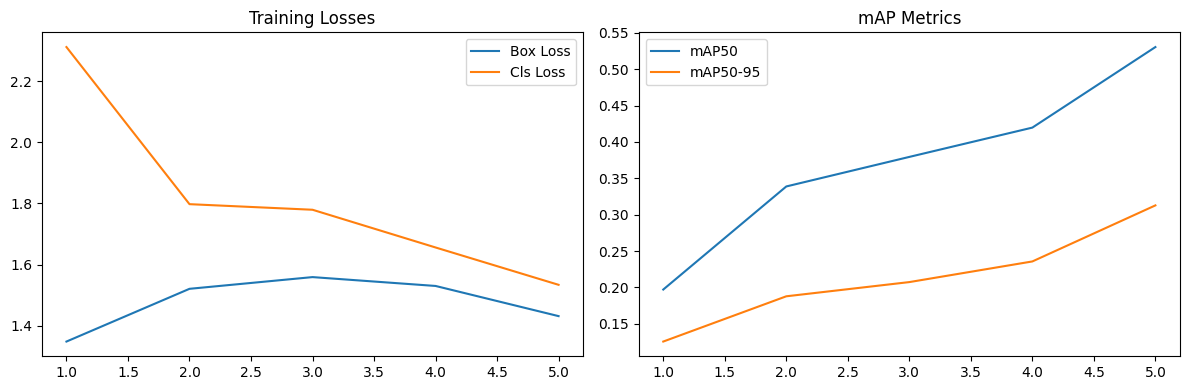

In [ ]:
# Carregar modelo pré-treinado e desativar W&B
model = YOLO("yolo11n.pt")  # pré-treinado

# Verificar dataset
train_dir = Path("data/coco/images/train")
val_dir   = Path("data/coco/images/val")
print("Diretório train existe:", train_dir.exists())
print("Diretório val existe:", val_dir.exists())
print("Número de imagens em train:", len(list(train_dir.glob("*.jpg"))))
print("Número de labels em train:", len(list(Path("data/coco/labels/train").glob("*.txt"))))

# Treinamento
results = model.train(
    data="data/coco.yaml",
    imgsz=640,
    epochs=5,        # aumentar de 5 para melhorar acurácia
    batch=16,
    patience=5,
    project="runs",
    name="yolo_coco_treinamento",
    verbose=True,
    save=True,        # salvar checkpoints
    exist_ok=True,
    augment=True      # ativa augmentações
)

# === Avaliação no conjunto de teste ===
metrics = model.val(data="data/coco.yaml", split="test")

test_loss = (
    getattr(metrics, 'box_loss', 0) +
    getattr(metrics, 'cls_loss', 0) +
    getattr(metrics, 'dfl_loss', 0)
)
test_acc = getattr(metrics, 'metrics/precision(B)', 0)

print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

# === Plot de métricas usando results.csv ===
log_path = Path("runs/yolo_coco_treinamento/results.csv")
if log_path.exists():
    df = pd.read_csv(log_path)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    if "train/box_loss" in df.columns and "train/cls_loss" in df.columns:
        plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
        plt.plot(df["epoch"], df["train/cls_loss"], label="Cls Loss")
    plt.legend(); plt.title("Training Losses")

    plt.subplot(1,2,2)
    if "metrics/mAP50(B)" in df.columns and "metrics/mAP50-95(B)" in df.columns:
        plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50")
        plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP50-95")
    plt.legend(); plt.title("mAP Metrics")
    plt.tight_layout()
    plt.show()
else:
    print("Arquivo results.csv não encontrado.")

## 13. Predições em imagens de teste
- Selecionamos algumas imagens do conjunto de teste  
- Geramos predições com o modelo treinado  
- Exibimos os resultados diretamente no Colab  


0: 640x640 4 persons, 456.2ms
1: 640x640 6 persons, 2 cars, 456.2ms
2: 640x640 13 persons, 3 cars, 456.2ms
3: 640x640 10 persons, 456.2ms
4: 640x640 4 persons, 456.2ms
Speed: 3.0ms preprocess, 456.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/preds/sample
Predições das imagens aleatórias:


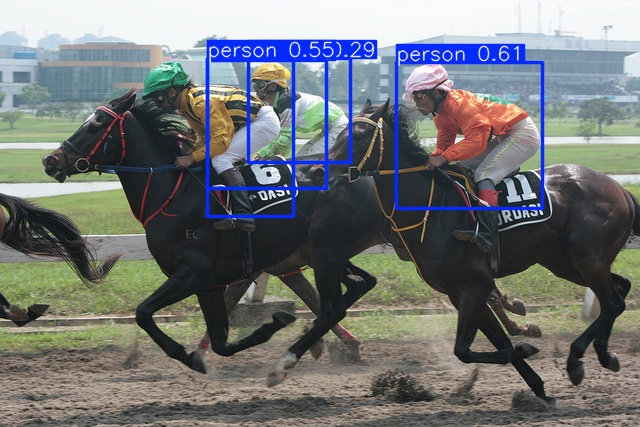

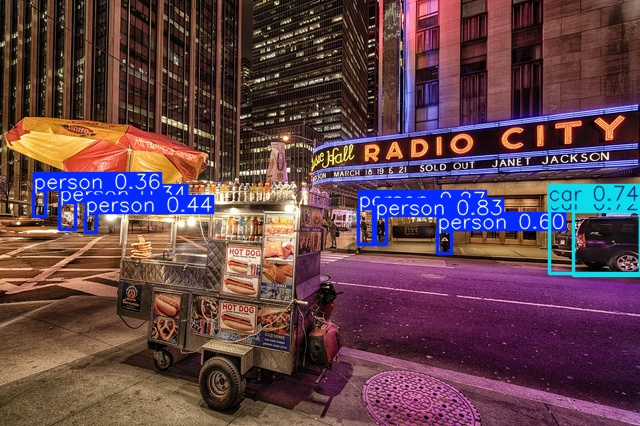

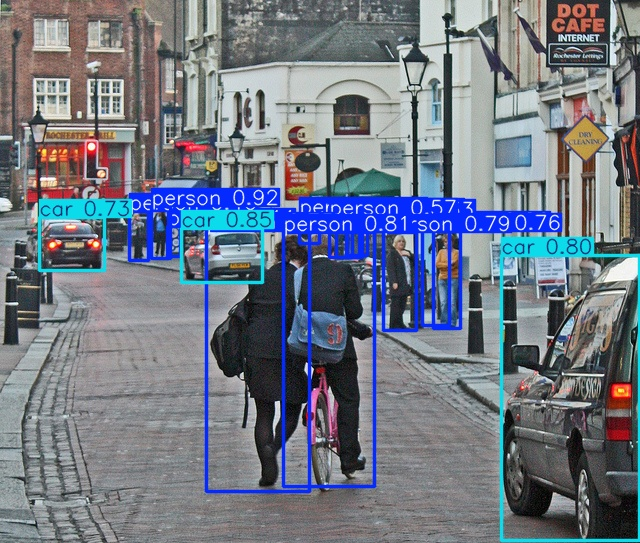

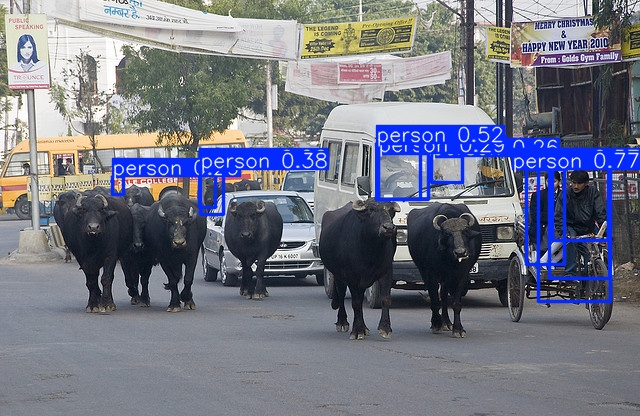

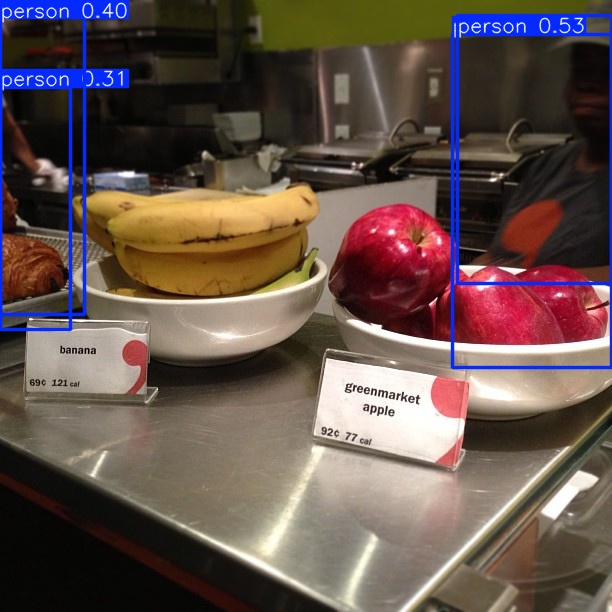

In [ ]:
from IPython.display import Image, display
from pathlib import Path
import random, glob

# Lista todas as imagens no diretório de teste
test_imgs = glob.glob("data/coco/images/test/*.jpg")

# Seleciona 5 imagens aleatórias para predição
random_imgs = random.sample(test_imgs, 5)

# Faz a predição e salva as imagens
preds = model.predict(
    random_imgs,
    conf=0.25,
    save=True,
    project="preds",
    name="sample",
    exist_ok=True
)

# Caminho das imagens preditas
pred_dir = Path("preds/sample")

# Exibe as imagens de predição correspondentes às imagens aleatórias
print("Predições das imagens aleatórias:")
for img_path in random_imgs:
    # Obtém o nome base da imagem original
    img_name = Path(img_path).name
    # Procura a imagem de predição correspondente (mesmo nome)
    pred_img_path = pred_dir / img_name
    if pred_img_path.exists():
        display(Image(filename=pred_img_path))
    else:
        print(f"Predição não encontrada para: {img_name}")